In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Printing config:
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.expand_frame_repr', False) # for printing full objects

# Running config:
input_file_path = './mappinghotelsdataset.xlsx'

p1_sheet_name = 'Partner1'
p2_sheet_name = 'Partner2'
example_sheet_name = 'examples'

In [2]:
# # # # # # HELPER FUNCTIONS # # # # # # 

def colNameListByDType(df, numericCols=True):
    # # # # # # # # # #
    # Finds the names of numeric/non-numeric columns of a dataframe
    # Args:
    #       df - (pandas dataframe)
    #       numericCols - (bool), True - for numerical columns, False - for non-numerical columns
    # Return:
    #       col_name_list - (list of strings), the matched columns name
    # # # # # # # # # #
    from pandas.api.types import is_numeric_dtype

    col_name_list = list()
    for col in df.columns:
        if(numericCols): # if the numeric columns are required
            if(is_numeric_dtype(df[col]) == True):
                col_name_list += [col]
        else:   # the non-numeric columns are required
            if (is_numeric_dtype(df[col]) == False):
                col_name_list += [col]

    # apply doesn't work with is_numeric_dtype for some reason!
    #if(numericCols):
    #    col_name_list = df.columns[df.apply(lambda x: is_numeric_dtype(x))]
    #else:
    #    col_name_list = df.columns[~np.array(df.apply(is_numeric_dtype))]

    return col_name_list

def getDfSliceRowIdx(df, colName, val):
    # # # # # # # # # #
    # Finds the row indices where colName == val in a dataframe
    # Args:
    #       df - (pandas dataframe)
    #       colName - (string)
    #       val - (string / int)
    # Return:
    #       (indices list), the row indices
    # # # # # # # # # #
    return df.loc[df[colName] == val].index  

In [3]:
# # # # # # DADA ANALYSIS # # # # # # 

def dataAnalysis(df):
    # # # # # # # # # #
    # Analyze dataframe
    # Args:
    #       df - (pandas datafrae)
    # Return:
    #       Nothing
    # # # # # # # # # #
    ignore_col_set = set(['p1.hotel_address', 'p2.hotel_address',
                       'p1.hotel_name', 'p2.hotel_name',
                       'p1.key', 'p2.key'])
    print("\nData shape : " + str(df.shape))  
    # Checking cols data type and existence of missing values 
    print(("\nData info: \n%s") % df.info())  
    print(("\nDMissing values: \n%s") % df.isnull().sum( )) 
    # Basic statistics:
    print(("\nSummary of numeric features: \n%s") % df.describe(include=[np.number]))  
    print(("\nSummary of non-numeric features: \n%s") % df.describe(include=['O'])) 

    non_numeric_cols = list(set(colNameListByDType(df, numericCols=False)) - ignore_col_set)
    for col in non_numeric_cols:
        print(("\nTop unique value (normed) count of column : %s\n%s") % 
                (col, df[col].value_counts(normalize=True)[:5]))

    return

In [4]:
# # # # # # HELPER FUNCTIONS for preprocessing # # # # # # 

def convertToAscii(df):
    # # # # # # # # # #
    # Convert all non-numeric columns of a dataframe to ASCII
    # Args:
    #       df - (pandas dataframe)
    # Return:
    #       df - (pandas dataframe) converted df
    # # # # # # # # # #
    import unidecode #conda install -c anaconda unidecode 
    
    def decode(x):
        if(isinstance(x, str)): 
            x = unidecode.unidecode(x)
        return x
    
    convert_cols = ['p1.city_name', 'p1.hotel_address', 'p1.hotel_name',
                   'p2.city_name', 'p2.hotel_address', 'p2.hotel_name',]
    
    for col in (set(convert_cols) & set(df.columns)):
        df.loc[:,col] = df.loc[:,col].apply(lambda x: decode(x))
    return df

def minMaxScaling(df, colsToScale):
    # # # # # # # # # #
    # Scale (MinMax) the specified columns of a dataset [0,1]
    # Note: the scaling is applied to the original df, no copy is made!
    # Args:
    #       df - (pandas dataframe), the dataset
    #       colsToScale - (list of strings), column names to scale.
    # Return:
    #       df - (pandas dataframe), the scaled dataset
    # # # # # # # # # #
    from sklearn.preprocessing import MinMaxScaler

    min_max_scaler = MinMaxScaler()
    df.loc[:, colsToScale] = min_max_scaler.fit_transform(df.loc[:, colsToScale])
    return df

def removePattern(sr, pattern="-"):
    # # # # # # # # # #
    # Remove pattern occurrances from series
    # Args:
    #       sr - (pandas series)
    #       pattern - (string)
    # Return:
    #       (pandas series), the series without the pattern
    # # # # # # # # # #
    def removePtrn(x, pattern):
        if(isinstance(x, str)): 
            x = x.replace(pattern, "")
        return x
    
    return sr.apply(lambda x: removePtrn(x, pattern))

In [5]:
# # # # # # DADA PREPROCESSING # # # # # # 

def preprocData(df):
    # # # # # # # # # #
    # Data preprocessing 
    # Args:
    #       df - (pandas dataframe)
    # Return:
    #       df - (pandas dataframe), preprocessed df
    # # # # # # # # # #
    
    # Convert all text columns to ASCII:
    df = convertToAscii(df)
    
    # Handle missing values:
    df.fillna('', inplace=True)
    
    # Scale star_rating to [0,1] scale:
    star_rating_name_list = list(set(['p1.star_rating', 'p2.star_rating']) & set(df.columns))
    df = minMaxScaling(df, star_rating_name_list)
    
    # Remove '-' occurrences in postal_code:
    postal_code_name_list = list(set(['p1.postal_code', 'p2.postal_code']) & set(df.columns))
    for i in postal_code_name_list:
        df.loc[:, i] = removePattern(df.loc[:, i], pattern="-")
    
    return df

In [6]:
# # # # # # HELPER FUNCTIONS for prediction # # # # # # 

def getTfidfFeatures(p1_sr, p2_sr, tf_threshold):
    # # # # # # # # # #
    # Generate tfidf features (fitted on both inputs)
    # Args:
    #       p1_sr - (pandas series of strings)
    #       p2_sr - (pandas seriesof strings)
    #       tf_threshold - (float [0,1]), represents the threshold for defining the stop words
    # Return:
    #       (p1_tfidf_csr, p2_tfidf_csr) - (tuple of numpy csr matrices), the tf-idf matrices
    # # # # # # # # # #
    from sklearn.feature_extraction.text import TfidfVectorizer

    vectorizer = TfidfVectorizer(max_df=tf_threshold, binary=True, analyzer='word', encoding='utf-8') #, decode_error='ignore') #min_df=1, 
    
    # Fit on both p1_sr and p2_sr:
    vectorizer = vectorizer.fit(pd.concat([p1_sr, p2_sr])) # error on address - AttributeError: 'int' object has no attribute 'lower', but works on hotel_name that also has numbers!!
    print(("\nVocabulary length: %d") % len(vectorizer.vocabulary_))
    print(("\nData-driven stop words - appeared in more than %d of the transactions:\n%s") % 
          (tf_threshold * (len(p1_sr)+len(p2_sr)), vectorizer.stop_words_))
    
    p1_tfidf_csr = vectorizer.transform(p1_sr) 
    p2_tfidf_csr = vectorizer.transform(p2_sr) 

    return (p1_tfidf_csr, p2_tfidf_csr)


# # # # # # HELPER FUNCTIONS - distance measurements # # # # # # 

def calcCosineSim(vec_csr, mat_csr):
    # # # # # # # # # #
    # Compute cosine similarity between a vector and a (row-normalized) matrix (of tfidf)
    # Args:
    #       vec_csr - (numpy sparse vector)
    #       mat_csr - (numpy sparse matrix)
    # Return:
    #       (list of floats), the dot product of the vector and the matrix
    # # # # # # # # # #
    from sklearn.metrics.pairwise import linear_kernel
    return linear_kernel(vec_csr, mat_csr).flatten()

def levenshteinDist(s1, s2):
    # Copied from (1st version): https://en.wikibooks.org/wiki/Algorithm_Implementation/Strings/Levenshtein_distance#Python
    if len(s1) < len(s2):
        return levenshteinDist(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

def levenshteinSim(s1, s2_sr):
    # # # # # # # # # #
    # Compute the similarity between a string and a vector of strings based on the levenshtein distance
    # similarity = 1 - (levenshtein(s1,s2)/max(len(s1),len(s2)))
    # Args:
    #       s1 - (string)
    #       s2_sr - (numpy series of strings)
    # Return:
    #       sim_list - (list of floats), list of similarities
    # # # # # # # # # #
    sim_list = []
    for s2 in s2_sr:
        if(len(s1) == 0 and len(s2) == 0): # both are empty
            sim_list.append(0)
        else:
            sim_list.append(1 - (levenshteinDist(s1,s2)/max(len(s1), len(s2))))
    return sim_list

In [11]:
# # # # # # PREDICTION # # # # # # 

def predictMatch(p1_df, p2_df, total_sim_threshold=2.5, tf_threshold=0.012):
    # # # # # # # # # #
    # Predict equal items in 2 dataframes 
    # Args:
    #       p1_df - (pandas dataframe)
    #       p2_df - (pandas dataframe)
    #       total_sim_threshold - (float [0,4]), represents the threshold for defining a match
    #       tf_threshold - (float [0,1]), represents the threshold for defining the stop words    
    # Return:
    #       matched_keys_list - (list of tuples of strings), list of the matched keys (p1.key, p2.key)
    # # # # # # # # # #
    
    # hotel_name tfidf matrices:
    print("\nApply tf-idf on hotel_name")
    p1_hotel_tfidf_csr, p2_hotel_tfidf_csr = getTfidfFeatures(p1_df['p1.hotel_name'], 
                                                                  p2_df['p2.hotel_name'], 
                                                                  tf_threshold=tf_threshold)    
    """
        # hotel_address tfidf matrices:
        print("\nApply tf-idf on hotel_address")
        print(type(p1_df['p1.hotel_address'].values.astype('U')))
        print(p1_df['p1.hotel_address'].values.astype('U'))

        #p1_add_tfidf_csr, p2_add_tfidf_csr = getTfidfFeatures(p1_df['p1.hotel_address'].values.astype('U'), 
        #                                                          p2_df['p2.hotel_address'].values.astype('U'), 
        #                                                          tf_threshold=0.012)    

    """
    
    matched_keys_list = []
    debug_matched_df = pd.DataFrame(columns=(list(p1_df.columns) + list(p2_df.columns)))

    for country in set(p1_df['p1.country_code']):
        p1_country_idx = getDfSliceRowIdx(p1_df, colName='p1.country_code', val=country)
        p2_country_idx = getDfSliceRowIdx(p2_df, colName='p2.country_code', val=country)
        #print(("\nDEBUG: country = %s; len(p1_country_idx): %d; len(p2_country_idx): %d") % 
        #      (country, len(p1_country_idx), len(p2_country_idx)))

        p2_not_matched_idx_list = list(p2_country_idx)
        
        for i in p1_country_idx:
            # If there are still p2 items left (not matched with the previous p1 items of this country)
            if(len(p2_not_matched_idx_list) > 0): 
                # p2_cols_sim_df is a dataframe that will contain the similarity scores of each column value of p1 row (index=i)
                # with all related p2 rows (same country):
                p2_cols_sim_df = pd.DataFrame()
                p2_cols_sim_df['p2_idx'] = p2_not_matched_idx_list

                # hotel_name similarity
                p2_cols_sim_df['hotel_name'] = calcCosineSim(p1_hotel_tfidf_csr[i,:], 
                                                             p2_hotel_tfidf_csr[p2_not_matched_idx_list,:])
                # city_name similarity:
                p2_cols_sim_df['city_name'] = levenshteinSim(p1_df.loc[i,'p1.city_name'], 
                                                             p2_df.loc[p2_not_matched_idx_list,'p2.city_name'])  
                # postal_code similarity:
                p2_cols_sim_df['postal_code'] = levenshteinSim(str(p1_df.loc[i,'p1.postal_code']), 
                                                               p2_df.loc[p2_not_matched_idx_list,'p2.postal_code'].apply(lambda x: str(x)))
                # star_rating similarity:
                p2_cols_sim_df['star_rating'] = list(p2_df.loc[p2_not_matched_idx_list,'p2.star_rating'].apply(
                                                lambda x: (1 - abs(x - p1_df.loc[i,'p1.star_rating']))))


                # Rename p2_cols_sim_df indices (original p2_df indices)
                p2_cols_sim_df = p2_cols_sim_df.set_index('p2_idx')

                #print(("\n\nDEBUG: i = %d;\np2_cols_sim_df:\n%s") %(i, p2_cols_sim_df))

                # Sum all similarity scores - represents the total similarity of p1 row (index=i) 
                # with all related p2 rows (same country):
                p2_total_sims = p2_cols_sim_df.sum(axis=1)

                #print(("\nDEBUG: total similarity:\n%s") % p2_total_sims)

                # Pick the most similar available p2 row 
                # (available = not matched yet with any of the previouse p1 rows):
                p2_max_sim_idx = p2_total_sims.idxmax()
                #print(("\nDEBUG: p2_max_sim_idx: %s") % str(p2_max_sim_idx))
                if p2_total_sims[p2_max_sim_idx] >= total_sim_threshold:
                    matched_keys_list.append((p1_df.loc[i,'p1.key'], p2_df.loc[p2_max_sim_idx, 'p2.key']))
                    debug_matched_df.loc[debug_matched_df.shape[0]] = list(p1_df.iloc[i]) + list(p2_df.iloc[p2_max_sim_idx])
                    #print(("\nDEBUG: p2_not_matched_idx_list BEFORE remove: %s") % p2_not_matched_idx_list)
                    p2_not_matched_idx_list.remove(p2_max_sim_idx)
                    #print(("\nDEBUG: p2_not_matched_idx_list AFTER remove: %s") % p2_not_matched_idx_list)

    #print(("\nMatched keys: %s") % matched_keys_list)

    # TODO: don't return debug_matched_df
    return matched_keys_list, debug_matched_df

In [12]:
# # # # # # EVALUATION # # # # # # 

def estimateResultsPerformance(pred_match_list, known_match_list):
    # # # # # # # # # #
    # Estimate the precision and recall of predictions compared to known matches.
    # Assumption - known_match_list keys are a subset of pred_match_list keys
    # Args:
    #       pred_match_list - (list of tuples), (p1.key, p2.key) list of predicted matches
    #       known_match_list - (list of tuples), (p1.key, p2.key) list of ground truth
    # Return:
    #       (precision, recall) - (tuple of floats)
    # # # # # # # # # #
    
    known_p1, known_p2 = zip(*known_match_list) # unzip known_match_list to p1.key and p2.key lists
    # Extract the relevant predictions for the evaluation procedure (p1.key or p2.key exist in known_match_list)
    pred_to_eval = [t for t in pred_match_list if (t[0] in known_p1 or t[1] in known_p2)]
    valid_pred = set(pred_to_eval) & set(known_match_list)
    # Precision (accuracy) estimation:
    precision = len(valid_pred)/len(pred_to_eval)
    print(("\nEstimated precision: %f") % precision)
    # Recall (coverage) estimation:
    recall = len(valid_pred)/len(known_match_list)
    print(("\nEstimated recall: %f") % recall)
    print(("\nDEBUG: len(pred_match_list): %d; len(known_match_list): %d; \nlen(pred_to_eval): %d; lev(valid_pred): %d;") %
         (len(pred_match_list), len(known_match_list), len(pred_to_eval), len(valid_pred)))
    
    return (precision, recall)

def evaluate(p1_df, p2_df, example_df, total_sim_threshold=3., tf_threshold=0.1):
    # # # # # # # # # #
    # Evaluate the prediction results when trained 2 dataframes, where example_df is a subset/all of the true matches
    # Args:
    #       p1_df - (pandas datafame)
    #       p2_df - (pandas datafame)
    #       example_df - (pandas datafame)
    #       total_sim_threshold - (float [0,4]), represents the threshold for defining a match
    #       tf_threshold - (float [0,1]), represents the threshold for defining the stop words    
    # Return:
    #       (precision, recall, matched_keys_list) - (tuple of 2 floats & 1 list)
    # # # # # # # # # #
    
    # Preprocess:
    p1_df = preprocData(p1_df)
    p2_df = preprocData(p2_df)
    
    # Predict matches:
    pred_matched_keys_list, debug_matched_df = predictMatch(p1_df, 
                                                            p2_df, 
                                                            total_sim_threshold,
                                                            tf_threshold)
    
    print(("DEBUG: len(pred_matched_keys_list): %d\ndebug_matched_df.shape: %s") % (len(pred_matched_keys_list), debug_matched_df.shape))
    
    # Extract the matched keys from example_df:
    matched_keys_list = list(zip(list(example_df.loc[:,'p1.key']), list(example_df.loc[:,'p2.key'])))
    
    # Evaluate the prediction results:
    precision, recall = estimateResultsPerformance(pred_matched_keys_list, matched_keys_list)
    
    return (precision, recall, pred_matched_keys_list)

def evaluateOnExampleOnly(example_df, total_sim_threshold=3., tf_threshold=0.1):
    # # # # # # # # # #
    # Evaluate the prediction results when trained on the example file only
    # Args:
    #       example_df - (pandas datafame)
    #       total_sim_threshold - (float [0,4]), represents the threshold for defining a match
    #       tf_threshold - (float [0,1]), represents the threshold for defining the stop words    
    # Return:
    #       (precision, recall, pred_matched_keys_list) - (tuple of 2 floats & 1 list)
    # # # # # # # # # #
    
    # Split example_df to 2 separated dataframes:
    p1_cols = [x.startswith("p1.") for x in example_df.columns]
    p2_cols = [x.startswith("p2.") for x in example_df.columns]
    p1_df = example_df.loc[:, p1_cols]
    p2_df = example_df.loc[:, p2_cols]
    #print(("DEBUG: p1_df.shape: %s\p2_df.shape: %s") % (p1_df.shape, p2_df.shape))
    
    # Evaluate:
    precision, recall, pred_matched_keys_list = evaluate(p1_df, p2_df, example_df, total_sim_threshold, tf_threshold)
    
    return (precision, recall, pred_matched_keys_list)

In [9]:
def writeOutputToFile(match_list, file_path='mappings.csv'):
    # # # # # # # # # #
    # Write matches (P1.key, P2.key) to csv file
    # Args:
    #       match_list - (list of tuples)
    #       file_path - (string)
    # Return:
    #       Nothing
    # # # # # # # # # #
    import csv

    with open(file_path, 'w') as out:
        csv_out = csv.writer(out)
        csv_out.writerow(['P1.key','P2.key'])
        for match in match_list:
            csv_out.writerow(match)
    return

def plotPerformace(df):
    # # # # # # # # # #
    # Plot the precision and recall per total_sim_threshold
    # Args:
    #       df - (pandas dataframe)
    # Return:
    #       Nothing
    # # # # # # # # # #
    import matplotlib.pyplot as plt
    
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.plot(df.loc[:,'total_sim_threshold'], df.loc[:,'precision'], label='precision')
    ax.plot(df.loc[:,'total_sim_threshold'], df.loc[:,'recall'], label='recall')
    ax.set_title('Performance per (total) similarity threshold', fontsize=15)
    ax.set_xlabel('total_sim_threshold', fontsize=10)
    ax.set_ylabel('performance', fontsize=10)
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,-0.2))
    #ax.grid('on')
    #fig.savefig('samplefigure', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()
    print(performance_df)
    
    return

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)



Apply tf-idf on hotel_name

Vocabulary length: 1055

Data-driven stop words - appeared in more than 22 of the transactions:
{'comfort', 'inn', 'and', 'guest', 'best', 'western', 'by', 'the', 'apartment', 'road', 'suites', 'hotel', 'house', 'resort', 'beach', 'hostel', 'villa'}
DEBUG: len(pred_matched_keys_list): 499
debug_matched_df.shape: (499, 14)

Estimated precision: 0.969940

Estimated recall: 0.969940

DEBUG: len(pred_match_list): 499; len(known_match_list): 499; 
len(pred_to_eval): 499; lev(valid_pred): 484;

Apply tf-idf on hotel_name

Vocabulary length: 1055

Data-driven stop words - appeared in more than 22 of the transactions:
{'comfort', 'inn', 'and', 'guest', 'best', 'western', 'by', 'the', 'apartment', 'road', 'suites', 'hotel', 'house', 'resort', 'beach', 'hostel', 'villa'}
DEBUG: len(pred_matched_keys_list): 499
debug_matched_df.shape: (499, 14)

Estimated precision: 0.969940

Estimated recall: 0.969940

DEBUG: len(pred_match_list): 499; len(known_match_list): 499; 
le


Apply tf-idf on hotel_name

Vocabulary length: 1055

Data-driven stop words - appeared in more than 22 of the transactions:
{'comfort', 'inn', 'and', 'guest', 'best', 'western', 'by', 'the', 'apartment', 'road', 'suites', 'hotel', 'house', 'resort', 'beach', 'hostel', 'villa'}
DEBUG: len(pred_matched_keys_list): 489
debug_matched_df.shape: (489, 14)

Estimated precision: 0.979550

Estimated recall: 0.959920

DEBUG: len(pred_match_list): 489; len(known_match_list): 499; 
len(pred_to_eval): 489; lev(valid_pred): 479;

Apply tf-idf on hotel_name

Vocabulary length: 1055

Data-driven stop words - appeared in more than 22 of the transactions:
{'comfort', 'inn', 'and', 'guest', 'best', 'western', 'by', 'the', 'apartment', 'road', 'suites', 'hotel', 'house', 'resort', 'beach', 'hostel', 'villa'}
DEBUG: len(pred_matched_keys_list): 486
debug_matched_df.shape: (486, 14)

Estimated precision: 0.979424

Estimated recall: 0.953908

DEBUG: len(pred_match_list): 486; len(known_match_list): 499; 
le


Apply tf-idf on hotel_name

Vocabulary length: 1055

Data-driven stop words - appeared in more than 22 of the transactions:
{'comfort', 'inn', 'and', 'guest', 'best', 'western', 'by', 'the', 'apartment', 'road', 'suites', 'hotel', 'house', 'resort', 'beach', 'hostel', 'villa'}
DEBUG: len(pred_matched_keys_list): 251
debug_matched_df.shape: (251, 14)

Estimated precision: 1.000000

Estimated recall: 0.503006

DEBUG: len(pred_match_list): 251; len(known_match_list): 499; 
len(pred_to_eval): 251; lev(valid_pred): 251;

Apply tf-idf on hotel_name

Vocabulary length: 1055

Data-driven stop words - appeared in more than 22 of the transactions:
{'comfort', 'inn', 'and', 'guest', 'best', 'western', 'by', 'the', 'apartment', 'road', 'suites', 'hotel', 'house', 'resort', 'beach', 'hostel', 'villa'}
DEBUG: len(pred_matched_keys_list): 220
debug_matched_df.shape: (220, 14)

Estimated precision: 1.000000

Estimated recall: 0.440882

DEBUG: len(pred_match_list): 220; len(known_match_list): 499; 
le

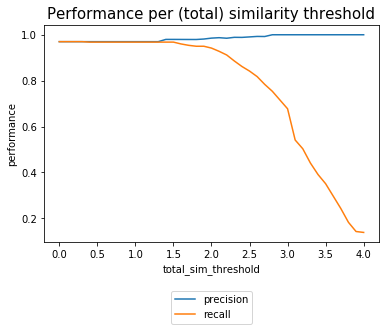

    total_sim_threshold  precision  recall  num_of_pairs
0                0.0000     0.9699  0.9699      499.0000
1                0.1000     0.9699  0.9699      499.0000
2                0.2000     0.9699  0.9699      499.0000
3                0.3000     0.9699  0.9699      499.0000
4                0.4000     0.9699  0.9679      498.0000
5                0.5000     0.9699  0.9679      498.0000
6                0.6000     0.9699  0.9679      498.0000
7                0.7000     0.9699  0.9679      498.0000
8                0.8000     0.9699  0.9679      498.0000
9                0.9000     0.9699  0.9679      498.0000
10               1.0000     0.9699  0.9679      498.0000
11               1.1000     0.9699  0.9679      498.0000
12               1.2000     0.9699  0.9679      498.0000
13               1.3000     0.9699  0.9679      498.0000
14               1.4000     0.9797  0.9679      493.0000
15               1.5000     0.9797  0.9679      493.0000
16               1.6000     0.9

In [13]:
# # # # evaluate model on example data with a range of total_sim_threshold - help defininf the parameter value # # # # # 

# Load the data
xls = pd.ExcelFile(input_file_path)
example_df = xls.parse(example_sheet_name, encoding='utf-8')

#dataAnalysis(example_df)

performance_df = pd.DataFrame(columns=['total_sim_threshold', 'precision', 'recall', 'num_of_pairs'])
for i in np.linspace(0, 4, 41):
    precision, recall, pred_list = evaluateOnExampleOnly(example_df, total_sim_threshold=i, tf_threshold=0.023)
    performance_df.loc[performance_df.shape[0]] = [i, precision, recall, len(pred_list)]

plotPerformace(performance_df)

In [14]:
# # # # # evaluate model on example data with the chosen total_sim_threshold parameter value # # # # #

# Load the data
xls = pd.ExcelFile(input_file_path)
example_df = xls.parse(example_sheet_name, encoding='utf-8')

precision, recall, pred_list = evaluateOnExampleOnly(example_df, total_sim_threshold=2.1, tf_threshold=0.023)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)



Apply tf-idf on hotel_name

Vocabulary length: 1055

Data-driven stop words - appeared in more than 22 of the transactions:
{'comfort', 'inn', 'and', 'guest', 'best', 'western', 'by', 'the', 'apartment', 'road', 'suites', 'hotel', 'house', 'resort', 'beach', 'hostel', 'villa'}
DEBUG: len(pred_matched_keys_list): 469
debug_matched_df.shape: (469, 14)

Estimated precision: 0.987207

Estimated recall: 0.927856

DEBUG: len(pred_match_list): 469; len(known_match_list): 499; 
len(pred_to_eval): 469; lev(valid_pred): 463;


In [15]:
# # # # # # predict matches between P1 & P2 data # # # # # # 

# Load the data
xls = pd.ExcelFile(input_file_path)
p1_df = xls.parse(p1_sheet_name, encoding='utf-8')
p2_df = xls.parse(p2_sheet_name, encoding='utf-8')

# Data analysis
#dataAnalysis(p1_df)
#dataAnalysis(p2_df)

# Preprocess:
p1_df = preprocData(p1_df)
p2_df = preprocData(p2_df)

# Predict matches:
pred_matched_keys_list, debug_matched_df = predictMatch(p1_df, 
                                                        p2_df, 
                                                        total_sim_threshold=2.1, 
                                                        tf_threshold=0.012)
writeOutputToFile(pred_matched_keys_list)


Apply tf-idf on hotel_name

Vocabulary length: 10843

Data-driven stop words - appeared in more than 240 of the transactions:
{'inn', 'quality', 'park', 'western', 'motel', 'grand', 'apartments', 'resort', 'guesthouse', 'beach', 'airport', 'branch', 'city', 'apartment', 'the', 'hotel', 'villa', 'house', 'hostel', 'spa', 'comfort', 'and', 'suites', 'lodge', 'guest', 'best', 'by', 'road', 'boutique'}
